21


  0%|          | 0/21 [00:00<?, ?it/s]

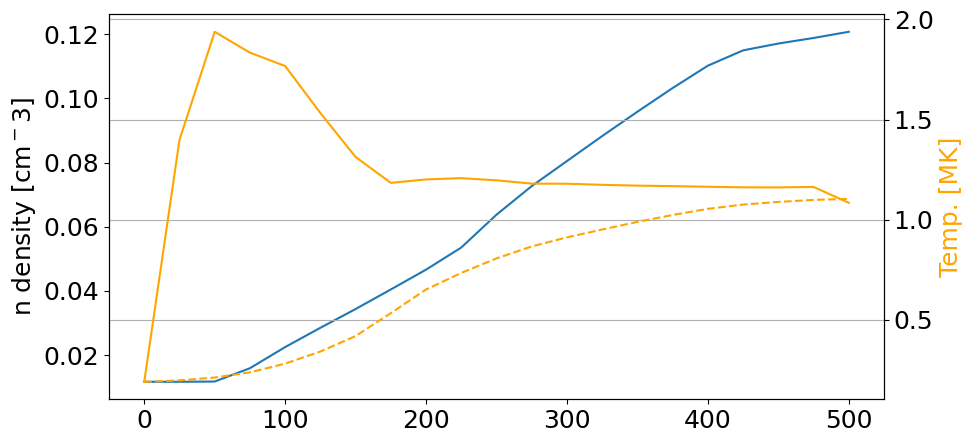

In [1]:
import importlib, numba, os, sys, time, pickle, resource, copy, glob
import numpy as np, scipy.ndimage as ndimage, astropy.units as u, matplotlib.pyplot as plt

from sys import path
from numpy.random import Generator, PCG64

from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from astropy.coordinates import SkyCoord

from tqdm.auto import tqdm

base_path = os.getcwd()
path.append(os.path.join(base_path,'modules'))

from aia_tresp import aia_temperature_response
plt.rcParams.update({'font.size': 18}) # Make the fonts in figures bigger
plt.rcParams.update({'figure.figsize':[17,8]})
plt.rcParams.update({'image.origin':'lower'})
np.set_printoptions(linewidth=160)

import pathlib
import tempfile

import astropy.units as u
from astropy.visualization import ImageNormalize, LogStretch

from pydrad.configure import Configure
from pydrad.configure.data import get_defaults
from pydrad.configure.util import get_clean_hydrad, run_shell_command
from pydrad.parse import Strand

tmpdir = 'hydrad_test' # pathlib.Path(tempfile.mkdtemp())  # Change to wherever you want to save your clean HYDRAD copy

#hydrad_results = os.path.join(tmpdir,'steady-run-double-heating')
#hydrad_results = os.path.join(tmpdir,'steady-run-double-heating-hr')
#hydrad_results = os.path.join(tmpdir,'steady-run-ebtel-sm')

hydrad_results = os.path.join(tmpdir,'steady-run-init-test')

s = Strand(hydrad_results)
#print(s)

#print(s.time)
#print(s.loop_length)
print(len(s))

import warnings
import logging

# Suppress pydrad warnings at the logging level
logging.getLogger('pydrad').setLevel(logging.ERROR)

# Or suppress all warnings from pydrad
warnings.filterwarnings('ignore', module='pydrad')

%matplotlib inline


lmax = np.max(s[0].coordinate.value)
nl = 1000
lengs = lmax*(0.5+np.arange(nl))/nl

dens=np.zeros([len(s),nl])
temp=np.zeros([len(s),nl])
temp_ion=np.zeros([len(s),nl])

l0 = s[0].coordinate.value

for i in tqdm(range(0,len(s))):
    dens[i] = np.interp(lengs, s[i].coordinate.value,s[i].hydrogen_density.value)
    temp[i] = np.interp(lengs, s[i].coordinate.value, s[i].electron_temperature.value)
    temp_ion[i] = np.interp(lengs, s[i].coordinate.value, s[i].hydrogen_temperature.value)

'''
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(s.time,dens.T[500]/1e9)
ax.set_ylabel(r'n density [cm$^-3$]')
ax2 = ax.twinx()
ax2.plot(s.time,temp.T[500]/1e6,color='orange')
ax2.plot(s.time,temp_ion.T[500]/1e6,color='orange',linestyle='dashed')
ax2.set_ylabel(r'Temp. [MK]',color='orange')

ax2.grid(True)
'''

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(s.time,dens.T[100:900].mean(axis=0)/1e9)
ax.set_ylabel(r'n density [cm$^-3$]')
ax2 = ax.twinx()
ax2.plot(s.time,temp.T[100:900].mean(axis=0)/1e6,color='orange')
ax2.plot(s.time,temp_ion.T[100:900].mean(axis=0)/1e6,color='orange',linestyle='dashed')
ax2.set_ylabel(r'Temp. [MK]',color='orange')

ax2.grid(True)

0.21490605921118763


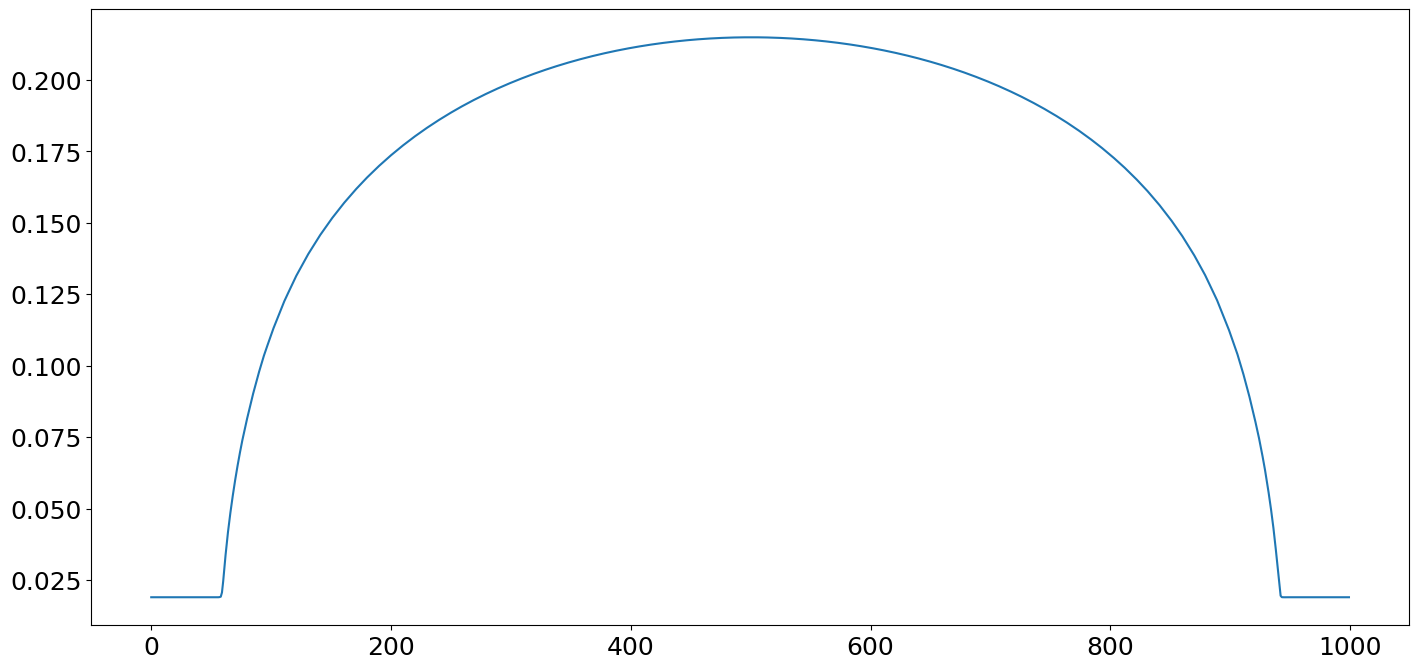

In [2]:
plt.plot(temp[0]/1e6)
print(temp[0].max()/1e6)

0.0055824894980531035
0.00558244215
0.00558244215


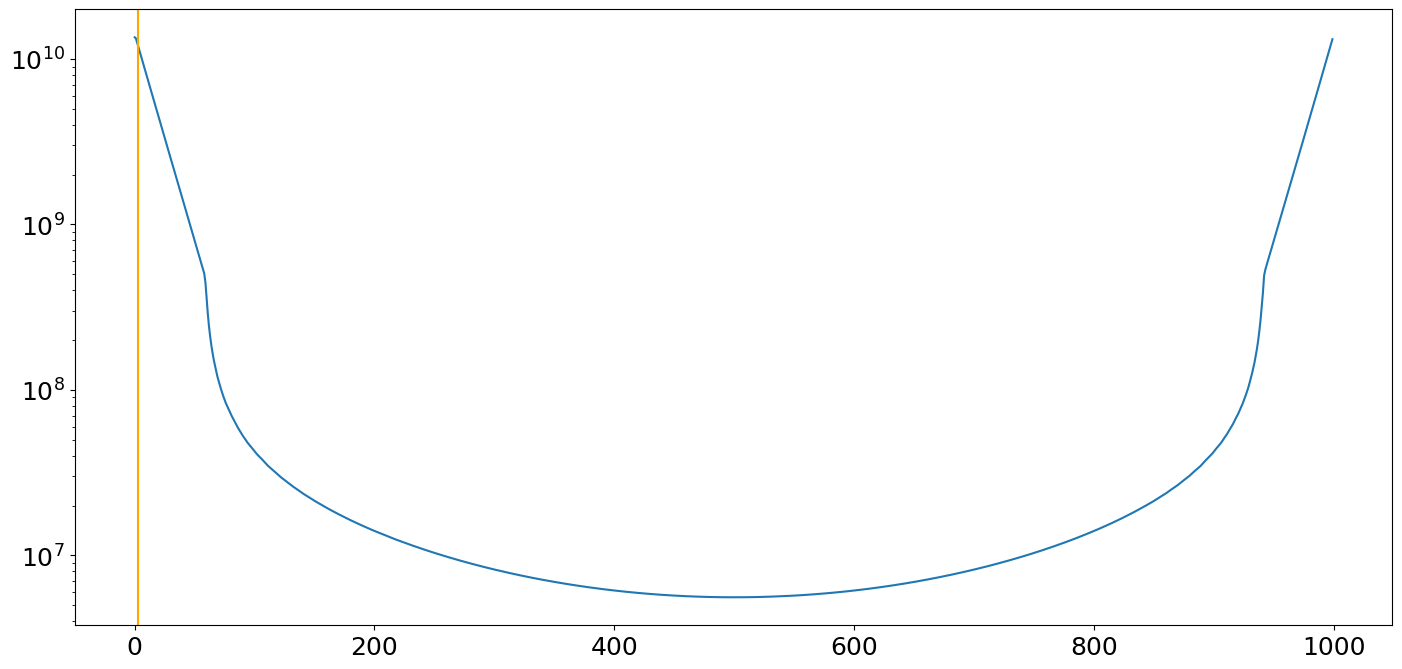

In [3]:
#plt.plot(s[0].coordinate,s[0].electron_density)

plt.plot(dens[0])
plt.yscale('log')
#plt.xlim(0,5)
plt.axvline(3,color='orange')
#plt.axhline(10.0e9,color='red')

print(dens[0].min()/1e9)
print(s[0].electron_density.min().value/1e9)
print(s[0].hydrogen_density.min().value/1e9)

In [5]:
i = s.time.value.shape[0]//2

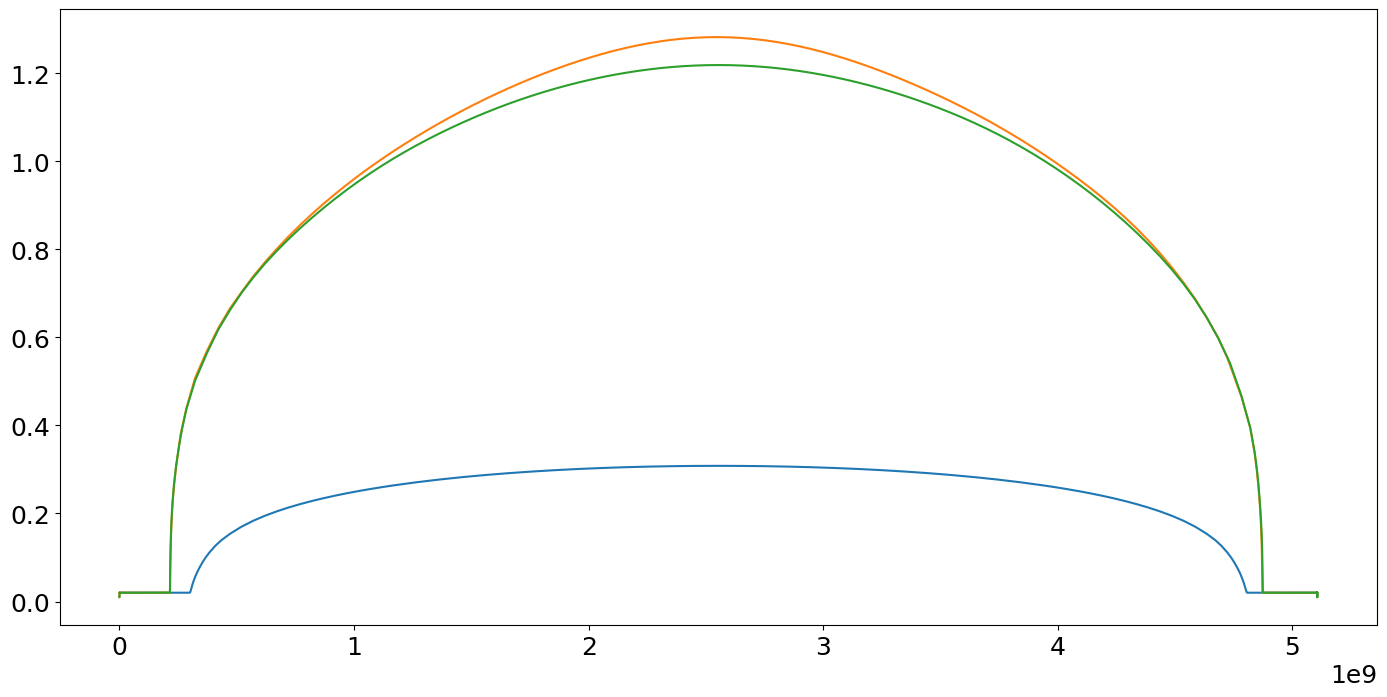

In [6]:
plt.plot(s[0].coordinate,s[0].electron_temperature/1e6)
plt.plot(s[i].coordinate,s[i].electron_temperature/1e6)
plt.plot(s[-1].coordinate,s[-1].electron_temperature/1e6)
#i+=1

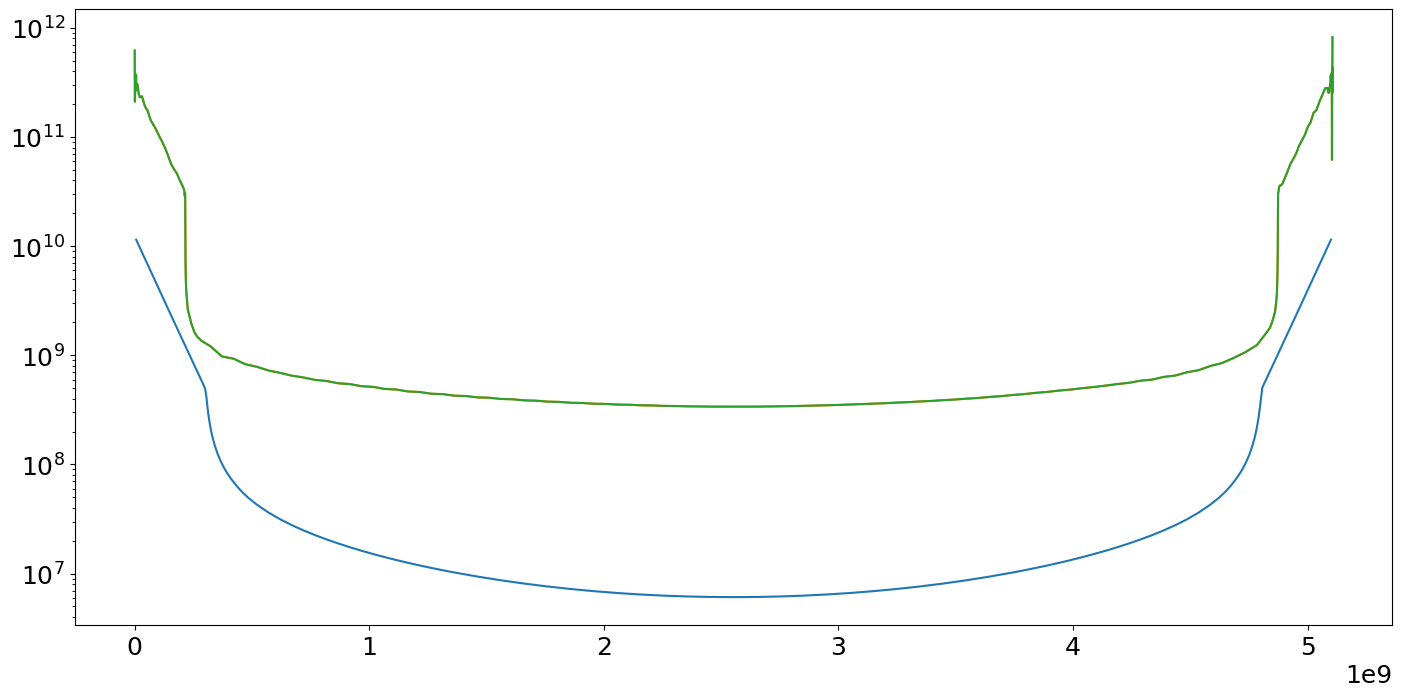

In [4]:
plt.plot(s[0].coordinate,s[0].electron_density)
plt.plot(s[i].coordinate,s[i].electron_density)
plt.plot(s[-1].coordinate,s[-1].electron_density)
plt.yscale('log')
#i+=1

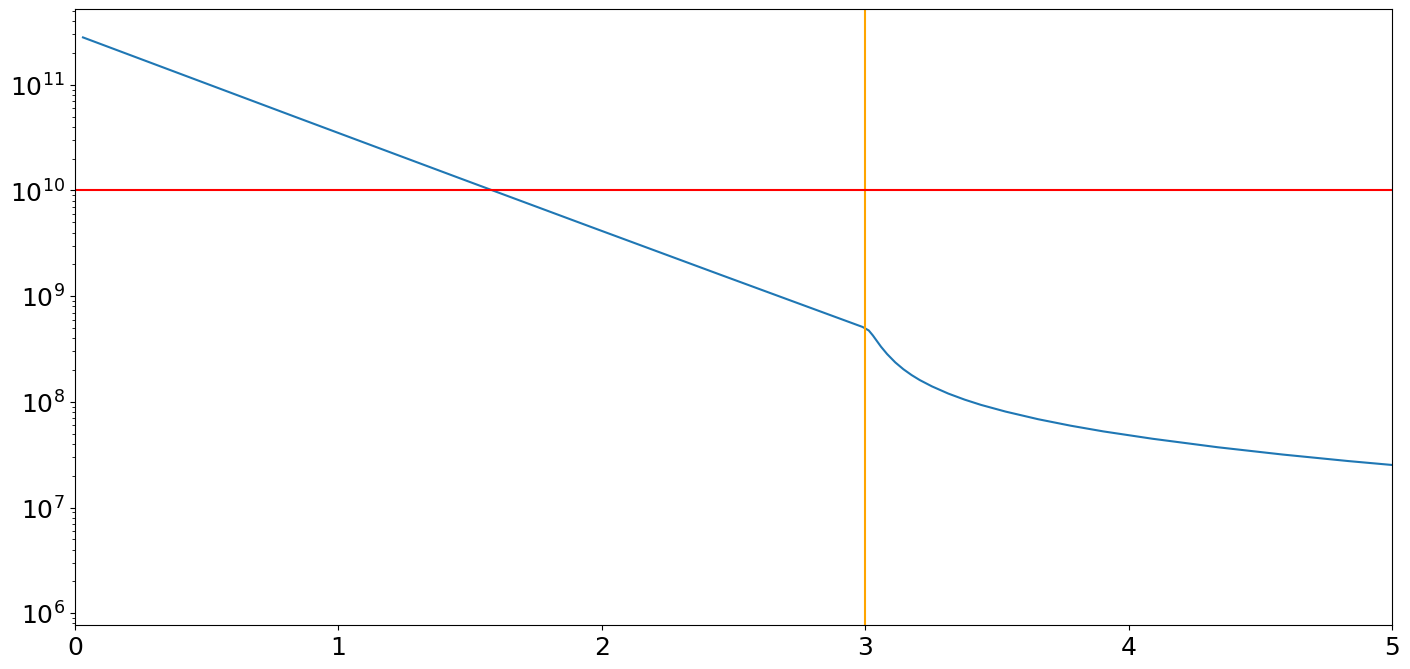

In [11]:
plt.plot(s[0].coordinate/1e8,s[0].electron_density)
plt.yscale('log')
plt.xlim(0,5)
plt.axvline(3,color='orange')
plt.axhline(10.0e9,color='red')
#plt.plot(s[i].coordinate,s[i].electron_density/1e6)
#plt.plot(s[-1].coordinate,s[-1].electron_density/1e6)

In [8]:
gen_images = False
save_dir = 'images/'

if gen_images:
    for j,p in enumerate(s):
        plt.plot(p.coordinate,p.electron_temperature/1e6)
        plt.savefig(f'{save_dir}temp_evolv_{j}.png',dpi = 100)
        plt.close()


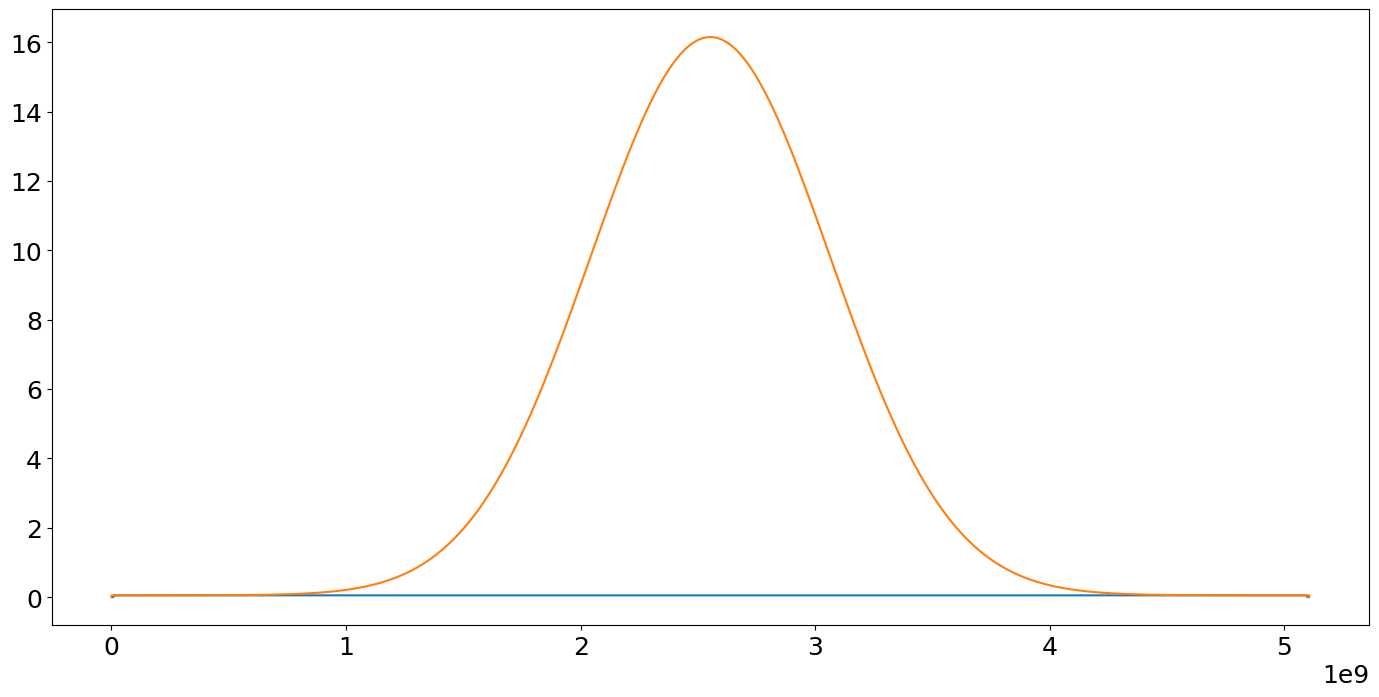

In [22]:
p = s[len(s)//2]
#p = s[0]

plt.plot(s[0].coordinate,s[0].electron_heating*1e5)
plt.plot(p.coordinate,p.electron_heating*1e5)

In [20]:
s[150].electron_heating[75]-s[0].electron_heating[75]

<Quantity 4.3e-05 erg / (s cm3)>

In [14]:
lmax = np.max(s[0].coordinate.value)
nl = 1000
lengs = lmax*(0.5+np.arange(nl))/nl
temp=np.zeros([len(s),nl])
l0 = s[0].coordinate.value
for i in range(0,len(s)):
	temp[i] = np.interp(lengs, s[i].coordinate.value, s[i].electron_temperature.value)

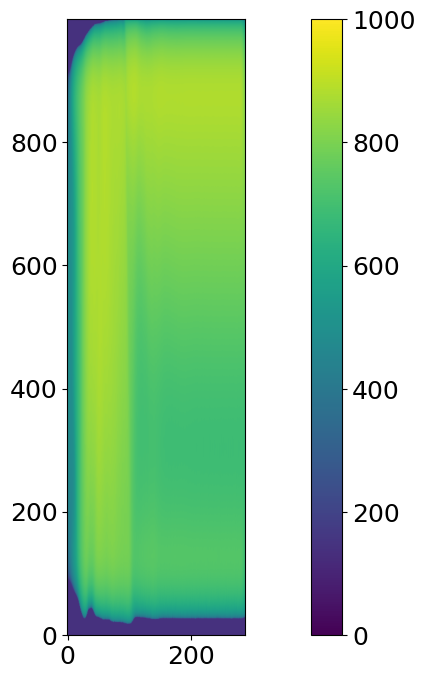

In [9]:
plt.imshow(temp.T**0.5,vmin=0,vmax=1.0e6**0.5)
plt.colorbar()

In [21]:
logt0, tresp0 = aia_temperature_response('AIA171_THIN')
logt = copy.deepcopy(logt0)
trtemp = 10**logt0
ntemp = trtemp.size

tmin, tmax, dt = 4.0, 7.5, 0.01
logt = tmin+(tmax-tmin)*np.arange(round((tmax-tmin)/dt)+1)/((tmax-tmin)/dt)
tresp = np.max(tresp0)*np.exp(-0.5*(logt-5.925)**2/0.1325**2)
trtemp = 10**logt0
trprof = np.interp(np.log10(temp),logt,tresp)
brprof = trprof*dens*dens

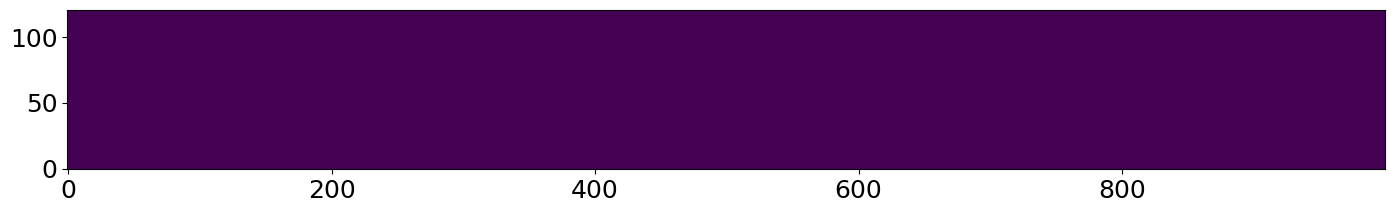

In [22]:
plt.imshow((brprof*1.0e8)**0.5,vmin=0,vmax=10**0.5)

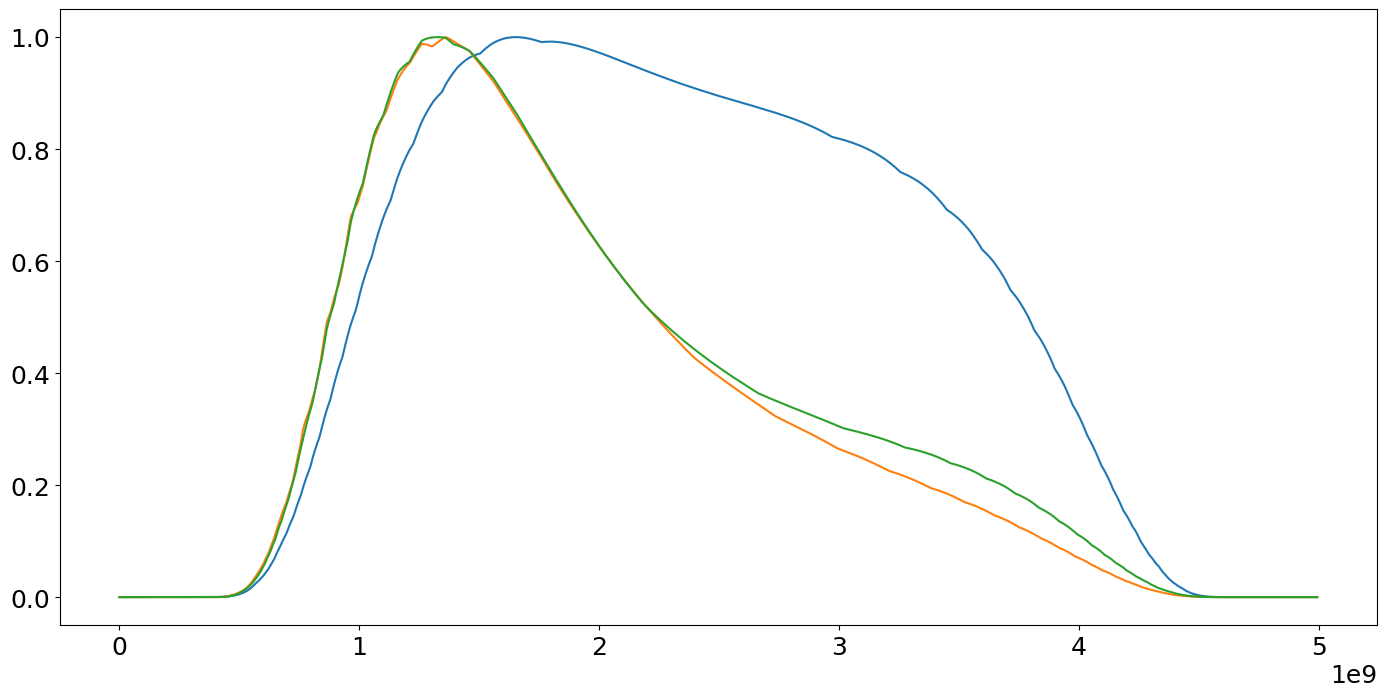

In [26]:
for i in range(0,3):
	plt.plot(lengs,brprof[10+25*i]/np.max(brprof[10+25*i]))
#plt.plot(lengs,brprof[100],lengs,brprof[125],lengs,brprof[150],lengs,brprof[175],lengs,brprof[200],lengs,brprof[225],lengs,brprof[250])

In [27]:
plt.plot(lengs,1.00*brprof[250]/np.max(brprof[250]))
plt.plot(lengs,np.exp(-0.5*(np.log(np.max(lengs)+lengs[0]-lengs)-np.log(0.029*np.max(lengs)))**2)+.54*np.exp(-0.5*(np.log(lengs)-np.log(0.0595*np.max(lengs)))**2/0.98**2))
#plt.plot(lengs,np.exp(-0.5*(np.log(np.max(lengs)+lengs[0]-lengs)-np.log(0.03*np.max(lengs)))**2))
#plt.plot(lengs,

IndexError: index 250 is out of bounds for axis 0 with size 121

In [18]:
lfrac = lengs/(0.5*lengs[0]+np.max(lengs))

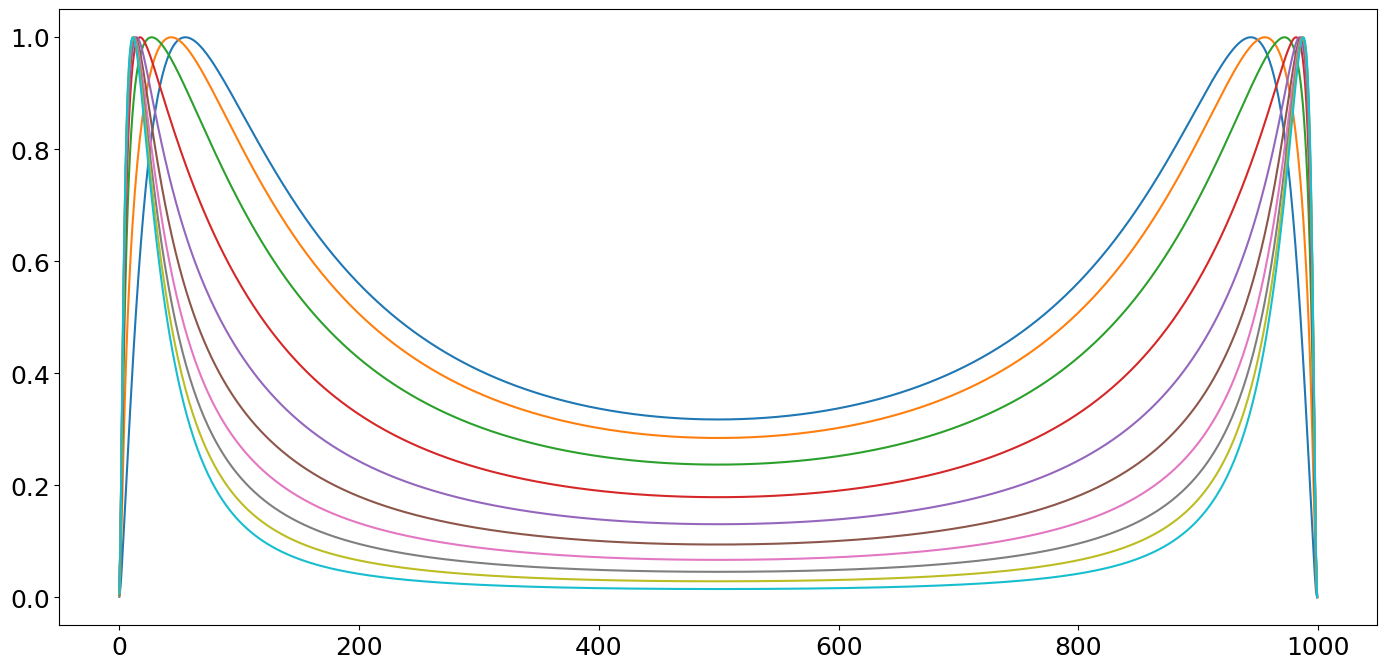

In [19]:
np.exp(np.log(0.025)+2)
f1 = np.exp(-0.5*(np.log(0.0225)-np.log(lfrac*(1-lfrac)))**2)/(lfrac*(1-lfrac))**(2/3)
f2 = np.exp(-0.5*(np.log(0.11)-np.log(lfrac*(1-lfrac)))**2)/(lfrac*(1-lfrac))**(2/3)
f3 = np.exp(-0.5*(np.log(0.5)-np.log(lfrac*(1-lfrac)))**2)/(lfrac*(1-lfrac))**(2/3)

#f1 = np.exp(-(np.log(0.03)-np.log(lengs/np.max(lengs)))**2)
#f2 = np.exp(-(np.log(0.11)-np.log(lengs/np.max(lengs)))**2)
#f3 = np.exp(-(np.log(0.5)-np.log(lengs/np.max(lengs)))**2)

for i in range(0,10): plt.plot(((0.05+0.1*i)*f1+(0.95-0.1*i)*f2)/np.max((0.05+0.1*i)*f1+(0.95-0.1*i)*f2))
#for i in range(0,10): plt.plot(np.diff((0.5+0.2*i)*f1+f2))
#plt.plot(f2)

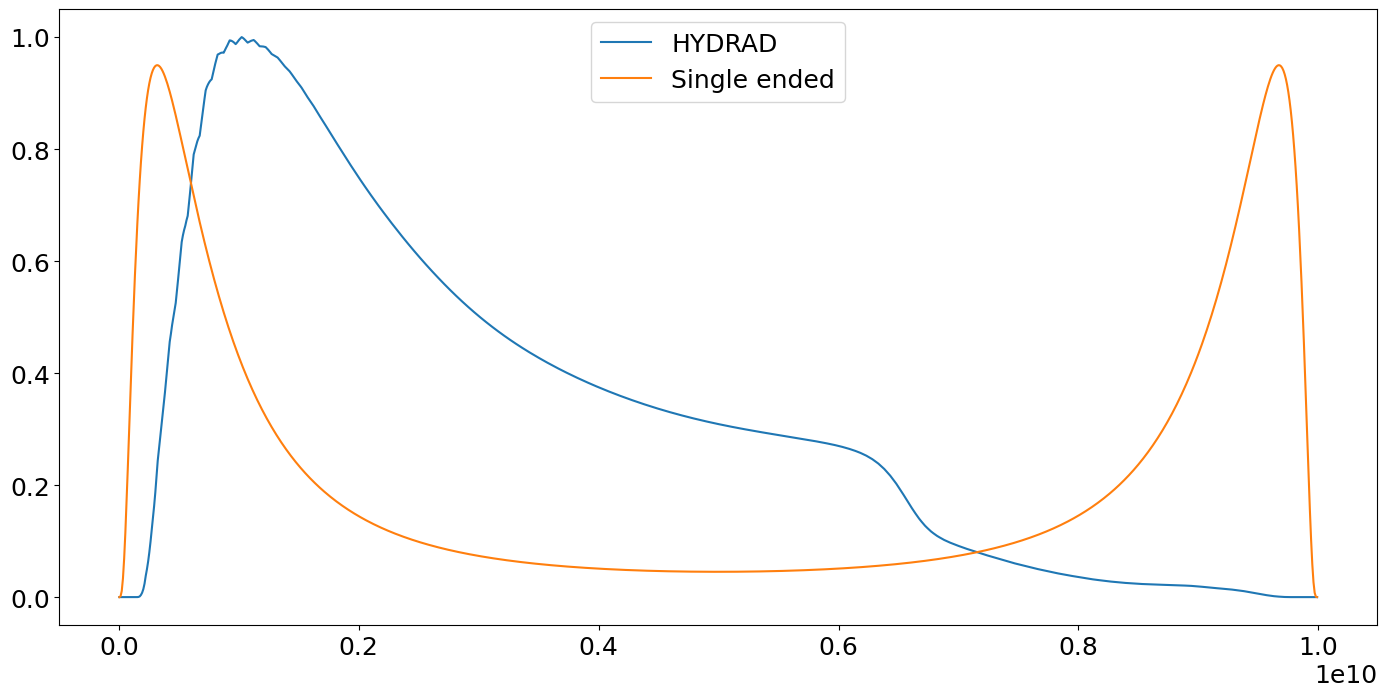

In [20]:
plt.plot(lengs,1.00*brprof[220]/np.max(brprof[220]))
#plt.plot(lengs,1.0*np.exp(-0.5*(np.log(0.027)-np.log(lfrac))**2)+0.9*np.exp(-0.5*(np.log(0.027)-np.log(1-lfrac))**2))
plt.plot(lengs,0.11*np.exp(-0.7*(np.log(0.05)-np.log(lfrac*(1-lfrac)))**2)/(lfrac*(1-lfrac))**(2/3))
plt.legend(['HYDRAD','Single ended','Double ended'])

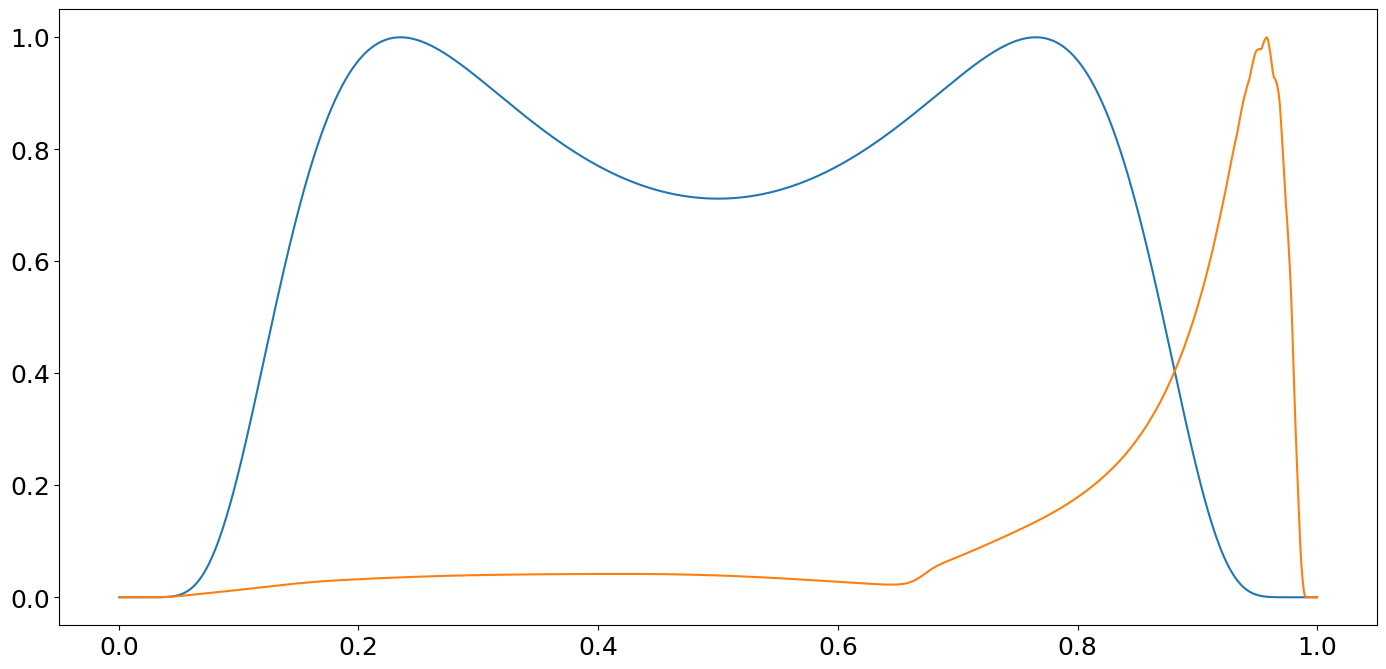

In [21]:
wid=0.4
test_prof = np.exp(-0.5*(np.log(0.2)-np.log(lfrac*(1-lfrac)))**2/wid**2)/(lfrac*(1-lfrac))**(2/3)
plt.plot(lfrac,test_prof/np.max(test_prof))
plt.plot(lfrac,brprof[100]/np.max(brprof[100]))

In [22]:
from scipy.optimize import least_squares

class resid_evaluator(object):
	def __init__(self,leng,dat,err,wid,cens,profile):
		self.lfrac=leng/(np.max(leng+0.5*leng[0]))
		self.dat=dat; self.err=err; self.wid=wid; self.cens=cens
		self.profiles = np.array(profile(self.lfrac,self.wid,self.cens)).T
	def get(self,parms):
		return (self.dat-np.sum(np.array(parms)*self.profiles,axis=1))/self.err
		#return (self.dat-self.profile(self.waves,parms))/self.err

def profiles_5pc(lfrac,wid,cens):
	profile1 = lfrac*np.exp(-0.5*(np.log(cens[0])-np.log(lfrac*(1-lfrac)))**2/wid**2)/(lfrac*(1-lfrac))**(2/3)
	profile2 = (1-lfrac)*np.exp(-0.5*(np.log(cens[0])-np.log(lfrac*(1-lfrac)))**2/wid**2)/(lfrac*(1-lfrac))**(2/3)
	profile3 = lfrac*np.exp(-0.5*(np.log(cens[1])-np.log(lfrac*(1-lfrac)))**2/wid**2)/(lfrac*(1-lfrac))**(2/3)
	profile4 = (1-lfrac)*np.exp(-0.5*(np.log(cens[1])-np.log(lfrac*(1-lfrac)))**2/wid**2)/(lfrac*(1-lfrac))**(2/3)
	profile5 = np.exp(-0.5*(np.log(0.25)-np.log(lfrac*(1-lfrac)))**2/wid**2)/(lfrac*(1-lfrac))**(2/3)
	return profile1/np.max(profile1),profile2/np.max(profile2),profile3/np.max(profile3),profile4/np.max(profile4),profile5/np.max(profile5)

# solution = least_squares(resid.get, guess_final, bounds=(lbounds,ubounds), x_scale=xscales)	

In [23]:
def fit_profile_leasq(leng, profile, err, wid, cens):
	nparm = 5
	guess = np.ones(nparm)*np.mean(profile)/nparm
	ubounds = np.ones(nparm)*np.max(profile)*1.5
	lbounds = np.zeros(nparm)

	resid = resid_evaluator(leng, profile, err, wid, cens, profiles_5pc)
	solution = least_squares(resid.get, guess, bounds=(lbounds,ubounds))
	return solution

In [28]:
cens = [0.08, 0.16]
wid = 0.4
profs_fit = np.zeros(brprof.shape)
for i in range(0,len(brprof)):
	prof = brprof[i]/np.max(brprof[i])
	err = 0.025*prof+0.025
	soln = fit_profile_leasq(lfrac, prof, err, wid,cens)
	profs_fit[i] = np.max(brprof[i])*np.sum(np.array(soln.x)*np.array(profiles_5pc(lfrac,wid,cens)).T,axis=1)

NameError: name 'fit_profile_leasq' is not defined

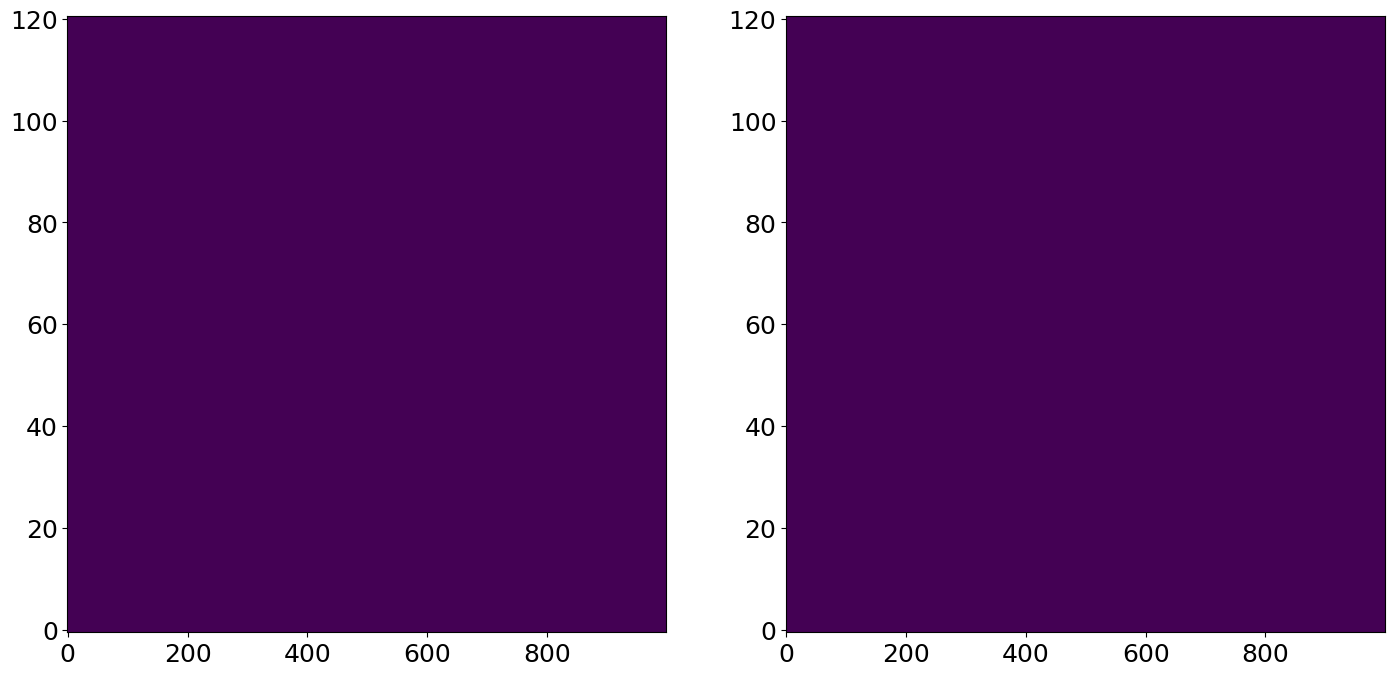

In [29]:
fig,axes = plt.subplots(nrows=1,ncols=2)
#plt.imshow(profs_fit)
axes[0].imshow((brprof*1.0e8)**0.5,vmin=0,vmax=100**0.5,aspect='auto')
axes[1].imshow((profs_fit*1.0e8)**0.5,vmin=0,vmax=100**0.5,aspect='auto')

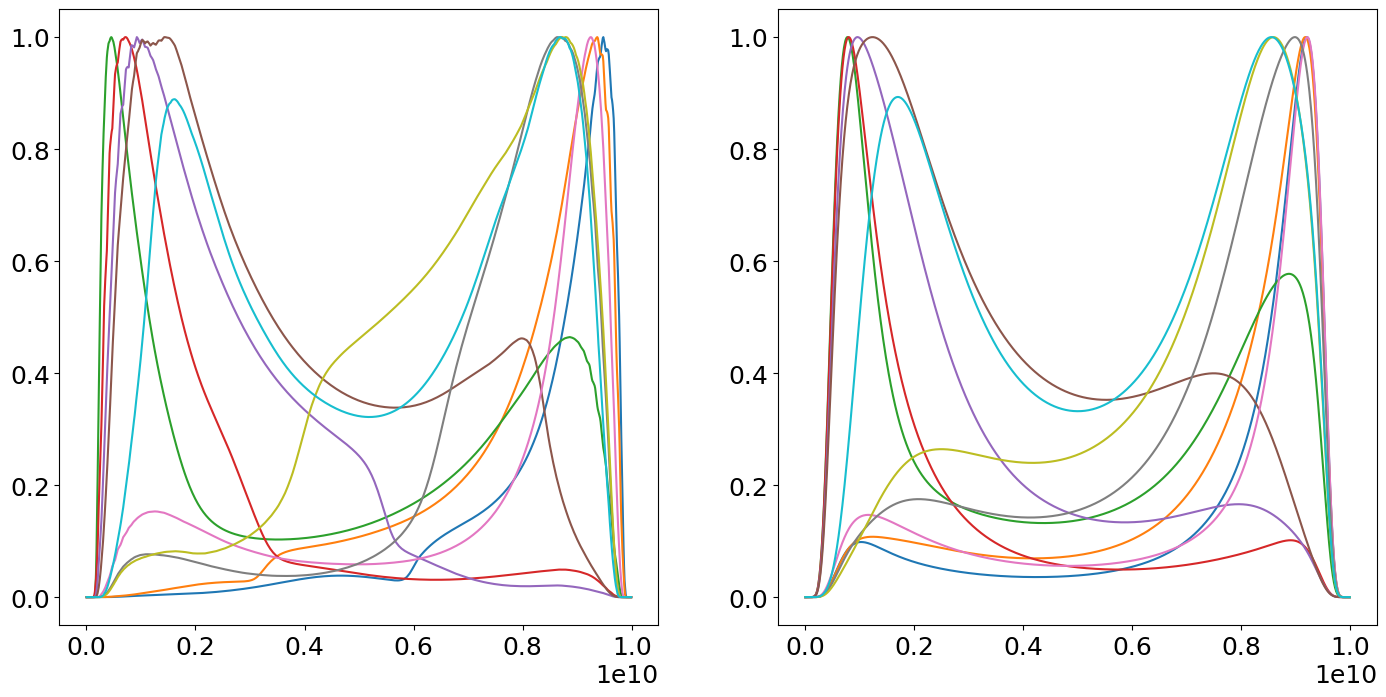

In [26]:
fig,axes = plt.subplots(nrows=1,ncols=2)
for i in range(0,10):
	axes[0].plot(lengs,brprof[110+25*i]/np.max(brprof[110+25*i]))
	axes[1].plot(lengs,profs_fit[110+25*i]/np.max(profs_fit[110+25*i]))
	

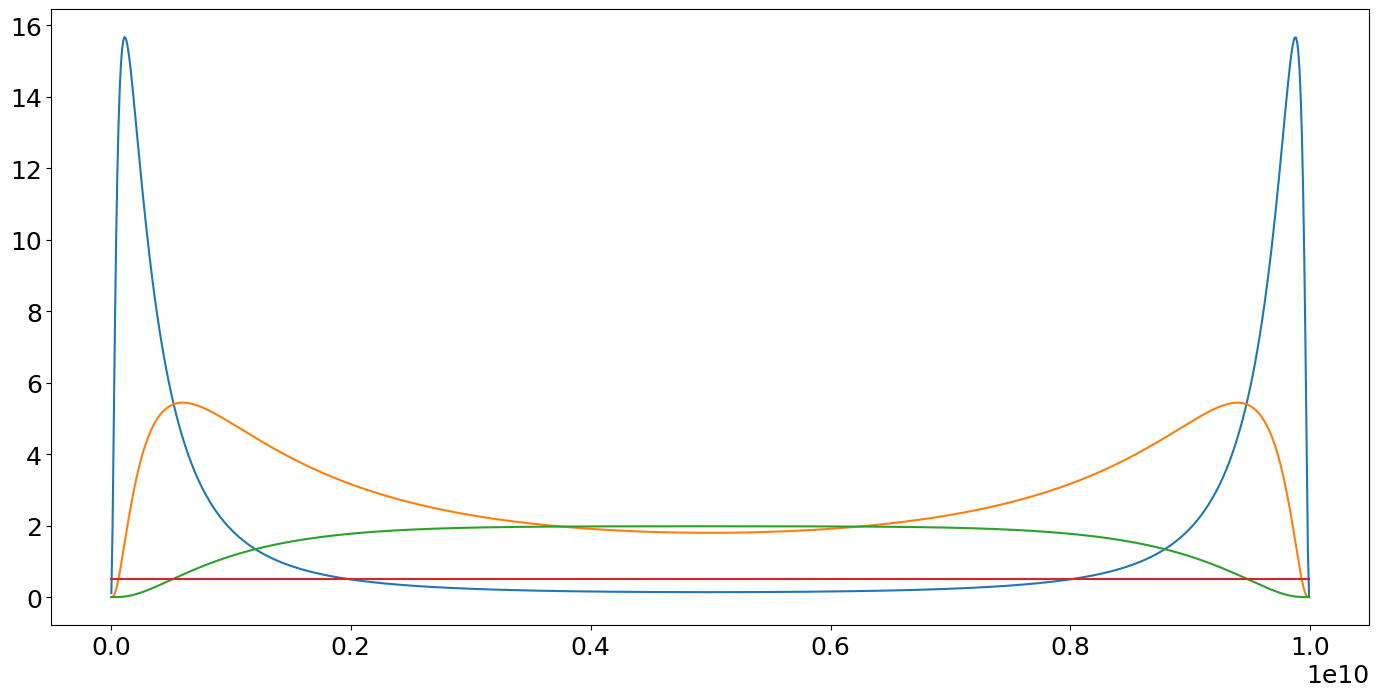

In [27]:
plt.plot(lengs,f1)
plt.plot(lengs,f2)
plt.plot(lengs,f3)
plt.plot([np.min(lengs),np.max(lengs)],[0.5,0.5])

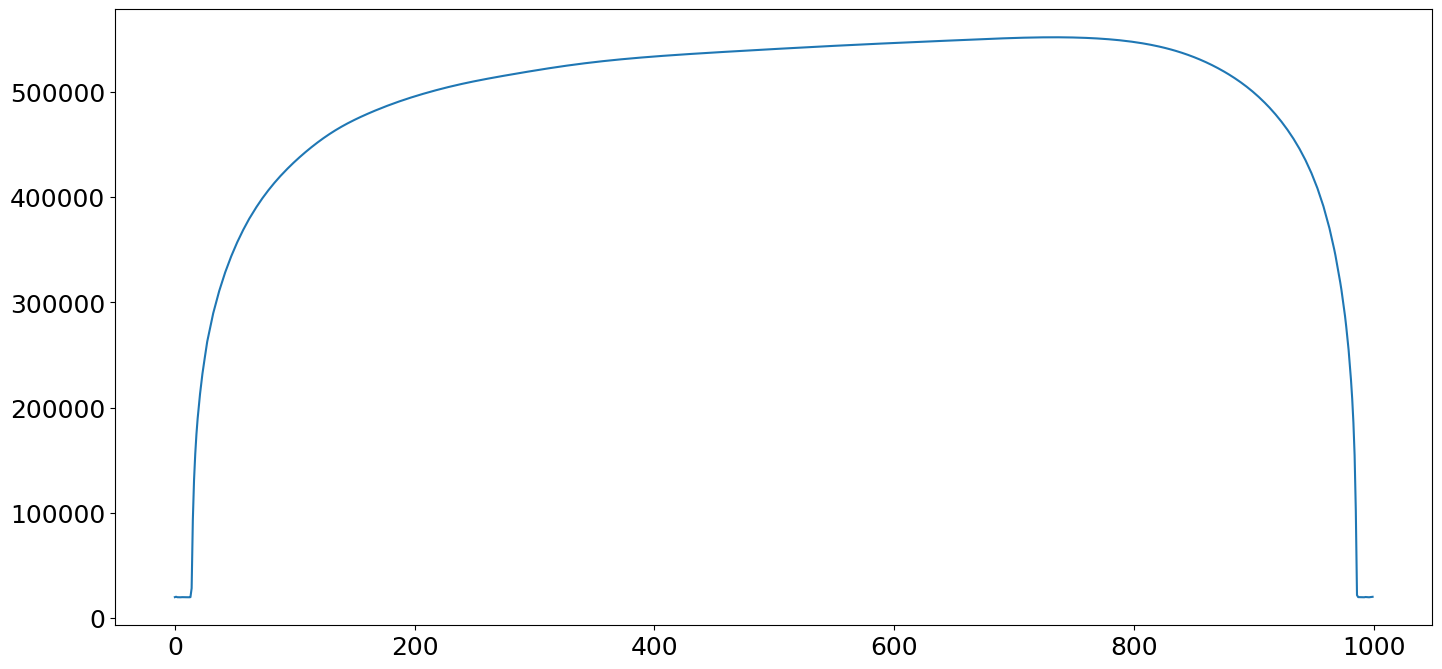

In [28]:
plt.plot(temp[250])

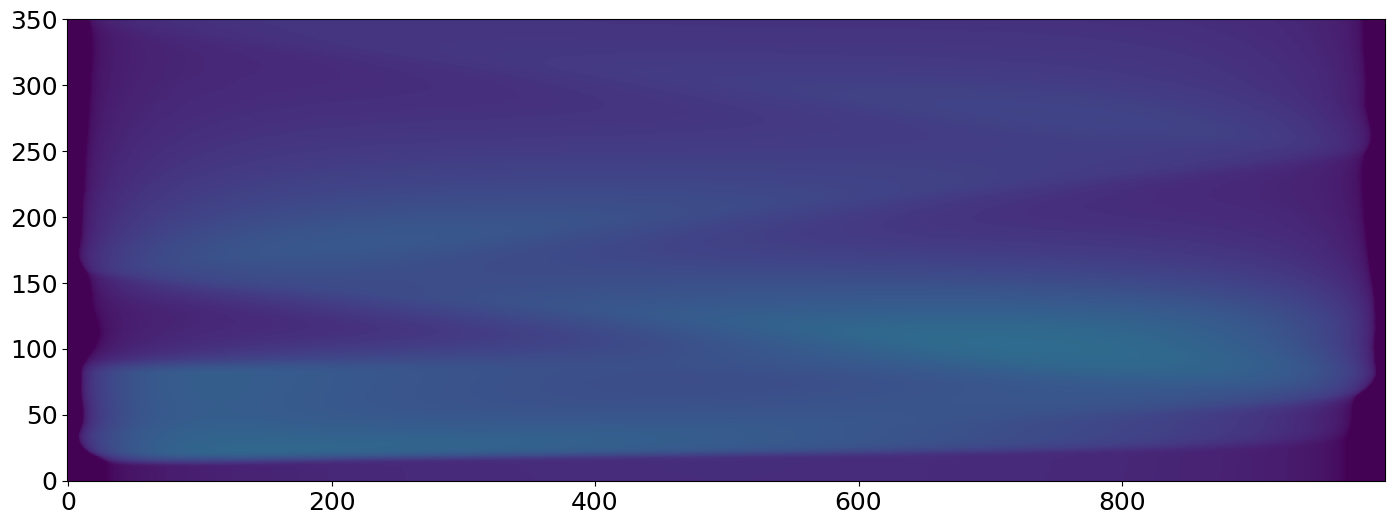

In [29]:
plt.imshow(temp,vmin=0,vmax=3.0e6)

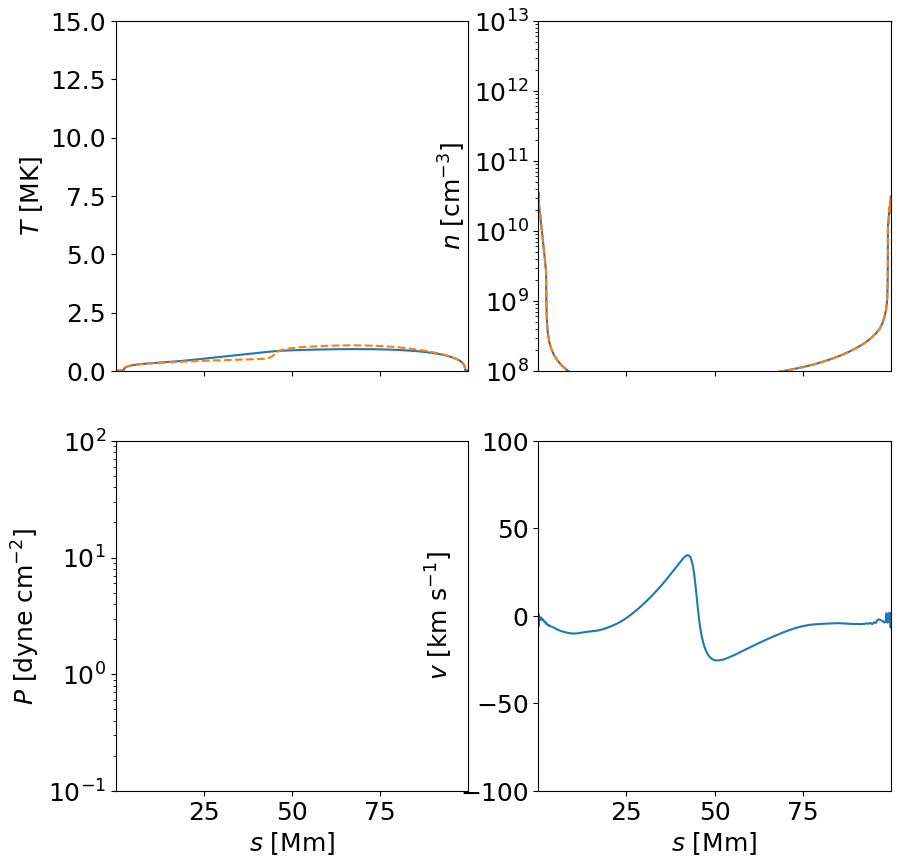

In [30]:
p.peek()

In [31]:
logt0, tresp0 = aia_temperature_response('AIA171_THIN')
logt = copy.deepcopy(logt0)
trtemp = 10**logt0
ntemp = trtemp.size

tmin, tmax, dt = 4.0, 7.5, 0.01
logt = tmin+(tmax-tmin)*np.arange(round((tmax-tmin)/dt)+1)/((tmax-tmin)/dt)
tresp = np.max(tresp0)*np.exp(-0.5*(logt-5.925)**2/0.1325**2)
trtemp = 10**logt0

In [32]:
def loop_profile(temp, logt, tresp, temp0=1.0e6, dens0=1.0e8, nlhalf = 50):
	nl = 2*nlhalf+1
	
	lbin_cents = (np.arange(nl)+0.5)/nl
	tprof0 = (((4*(lbin_cents)*(1-lbin_cents))+0.00)/1.00)**(1.0/3.0) # Based on Martens 2010
	tprof = np.clip(tprof0*temp,1.0e4,None)
	
	pscal = (temp/temp0)**3
	dprof = dens0*pscal*temp0/tprof

	trprof = np.interp(np.log10(tprof),logt,tresp)
	brprof = trprof*dprof*dprof

	return lbin_cents, tprof, dprof, trprof, brprof

In [33]:
p.coordinate

<Quantity [3.90625000e+05, 1.17187500e+06, 2.34375000e+06, 4.68750000e+06, 9.37500000e+06, 1.87500000e+07, 3.12500000e+07, 4.37500000e+07, 5.62500000e+07,
           6.87500000e+07, 8.75000000e+07, 1.06250000e+08, 1.18750000e+08, 1.31250000e+08, 1.43750000e+08, 1.56250000e+08, 1.68750000e+08, 1.81250000e+08,
           1.93750000e+08, 2.03125000e+08, 2.09375000e+08, 2.14062500e+08, 2.16406250e+08, 2.17968750e+08, 2.19140625e+08, 2.19921875e+08, 2.20703125e+08,
           2.21484375e+08, 2.22656250e+08, 2.24218750e+08, 2.26562500e+08, 2.29687500e+08, 2.32812500e+08, 2.35937500e+08, 2.40625000e+08, 2.46875000e+08,
           2.56250000e+08, 2.68750000e+08, 2.87500000e+08, 3.12500000e+08, 3.37500000e+08, 3.75000000e+08, 4.25000000e+08, 4.75000000e+08, 5.25000000e+08,
           5.75000000e+08, 6.25000000e+08, 6.75000000e+08, 7.25000000e+08, 7.75000000e+08, 8.25000000e+08, 8.75000000e+08, 9.25000000e+08, 9.75000000e+08,
           1.02500000e+09, 1.07500000e+09, 1.12500000e+09, 1.17500000e

In [34]:
leng = p.coordinate
temp = (p.electron_temperature)
dens = (p.hydrogen_density)

In [35]:
trprof = np.interp(np.log10(temp.to(u.K).value),logt,tresp)
brprof = trprof*dens*dens

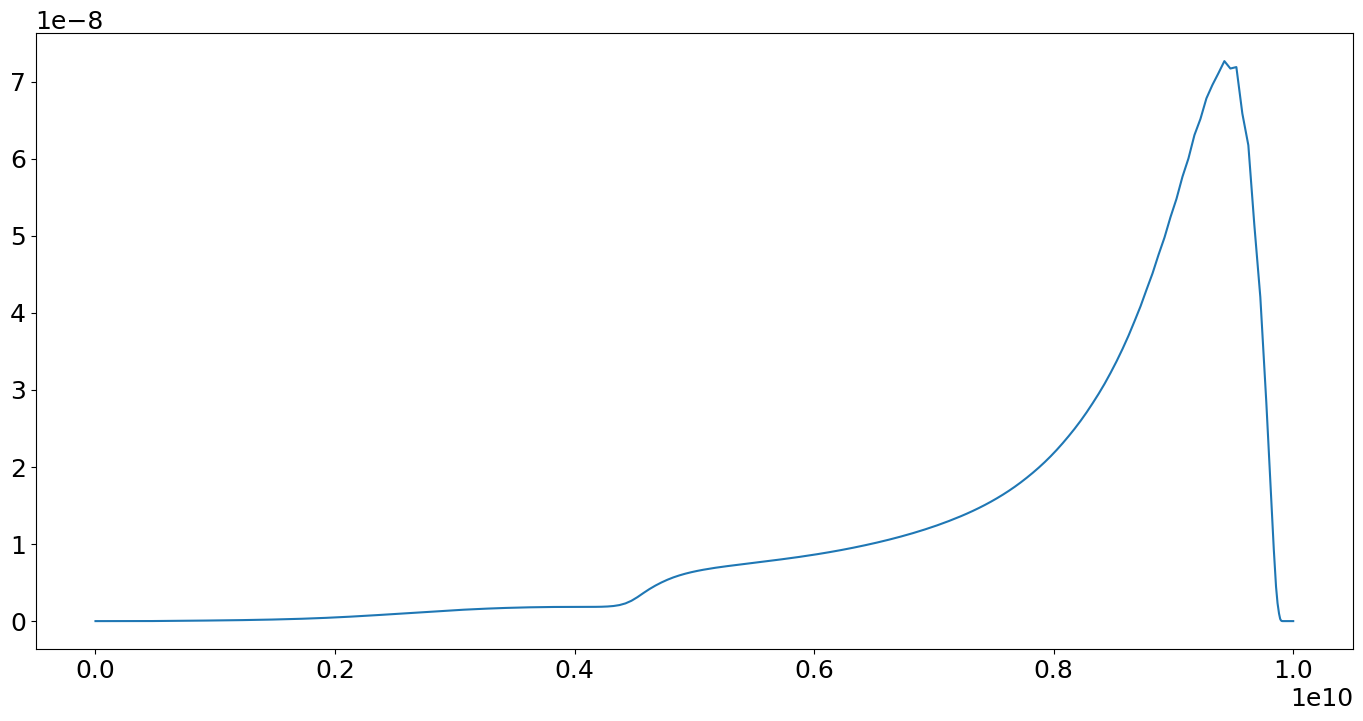

In [36]:
plt.plot(leng,brprof)

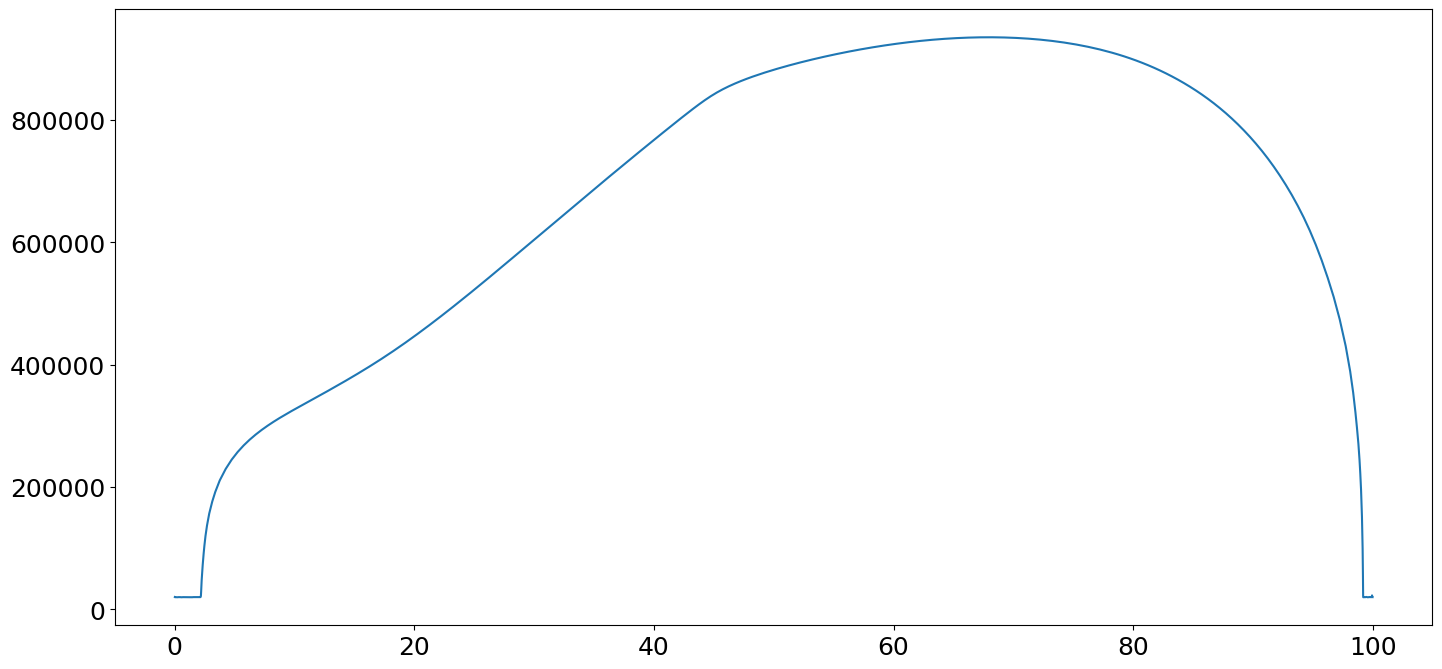

In [37]:
plt.plot(leng/1e8,temp)#/1.0e6)

[(0.0, 1000000000.0)]

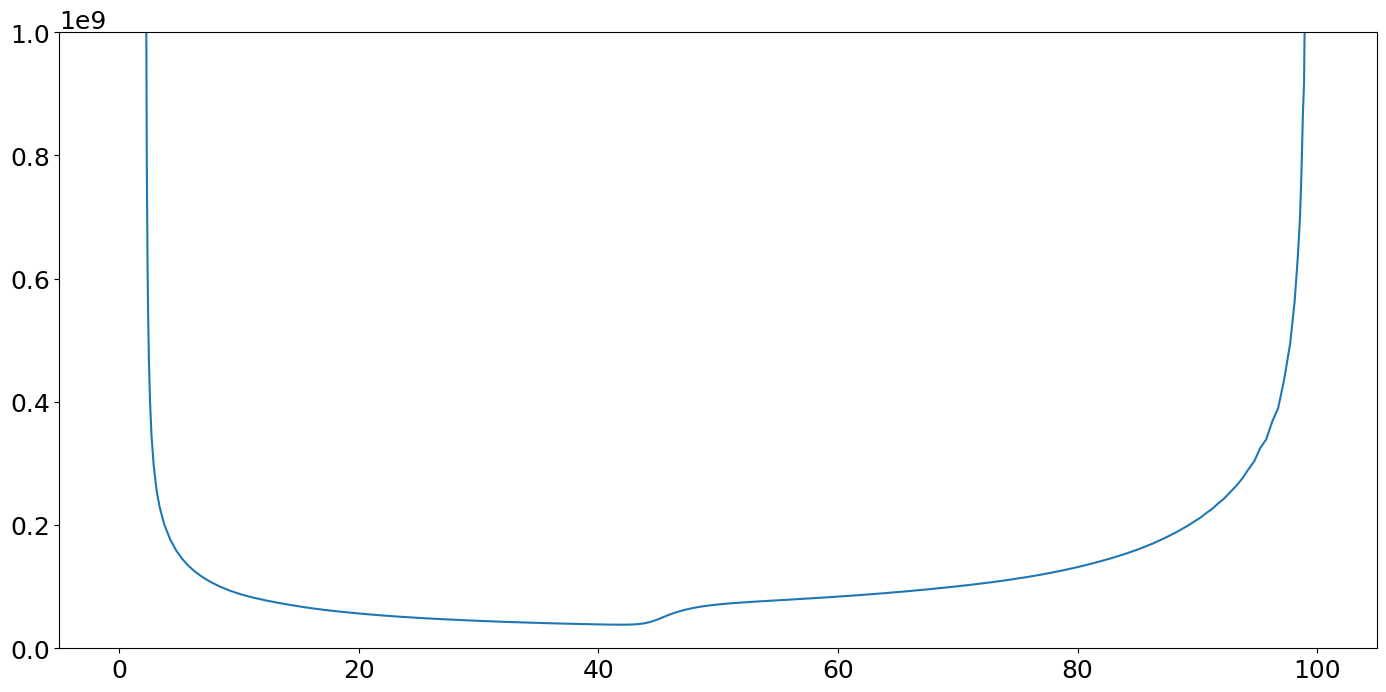

In [38]:
fig,ax=plt.subplots()
ax.plot(leng/1e8,dens.to(u.cm**(-3)).value); ax.set(ylim=[0,1.0e9])